# Xor

Now let's try a slightly harder example - the XOR function. Unlike AND or OR, it cannot be solved via a single perceptron, because it is not "linearly separable".

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from typing import List

%matplotlib inline

Xor is true (1 in this case) only when one of the inputs is true. If both or neither is true, then the result is false (or 0).

In [2]:
training_inputs = np.array([
    np.array([1, 1]),
    np.array([1, 0]),
    np.array([0, 1]),
    np.array([0, 0])
])

training_labels = np.array([0, 1, 1, 0])

In [3]:
def initialize_params(layer_dimensions: List[int]):
    parameters = {}
    numLayers = len(layer_dimensions)
    
    for l in range(1, numLayers):
        # Initialize weights to a small random number.
        parameters['W' + str(l)] = np.random.randn(layer_dimensions[l], layer_dimensions[l-1]) * 0.01
        # Initialize biases to zero.
        parameters['b' + str(l)] = np.zeros((layer_dimensions[l], 1))
        
        # Ensure that everything looks right.
        assert(parameters['W' + str(l)].shape == (layer_dimensions[l], layer_dimensions[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dimensions[l], 1))
    
    return parameters

In [4]:
def linear_forward(A, W, b):
    """
    The "linear" part of a layer's forward propagation.
    
    Arguments::
    A -- Activations from the previous layer.
    W -- Weights matrix.
    b -- Bias vector.
    """
    
    # Input to the activation function.
    Z = np.dot(W, A) + b
    # Values we'll need when doing backward propagation.
    cache = (A, W, b)
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    
    return Z, cache

In [5]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A, Z

def relu(Z):
    A = np.maximum(0, Z)
    return A, Z

In [6]:
def linear_activation_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)
    A, activation_cache = activation(Z)
    
    assert(A.shape == (W.shape[0], A_prev.shape[1]))
    
    cache = (linear_cache, activation_cache)
    return A, cache

In [7]:
def model_forward(X, parameters):
    """
    Forward propagation for each layer. Each layer is Linear->Relu, except
    for the output layer, which is Liner->Sigmoid.
    """
    
    caches = []
    # The initial "previous" layer is the inputs.
    A = X
    # The number of layers. Note that we divide by because the `parameters` contains
    # weights AND biases for each layer.
    numLayers = len(parameters) // 2
    
    # Relu layers
    for l in range(1, numLayers):
        A_prev = A
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        A, cache = linear_activation_forward(A_prev, W, b, relu)
        caches.append(cache)
        
    # Sigmoid layer
    W = parameters['W' + str(numLayers)]
    b = parameters['b' + str(numLayers)]
    Yhat, cache = linear_activation_forward(A, W, b, sigmoid)
    caches.append(cache)
    
    assert(Yhat.shape == (1, X.shape[1]))
    
    return Yhat, caches

In [8]:
def compute_cost(Yhat, Y):
    """
    Compute the cross-entropy cost.
    
    Arguments:
    Yhat -- Probability vector corresponding to label predictions.
    Y -- Actual label vector.
    """
    
    numExamples = Y.shape[1]
    
    cost = -(1 / numExamples) * np.sum(np.multiply(Y, np.log(Yhat)) + np.multiply(1 - Y, np.log(1 - Yhat)))
    return np.squeeze(cost)

In [9]:
def linear_backward(dZ, cache):
    """
    Linear part of backwards propagation.
    
    Arguments:
    dZ -- Derivative (gradient) of the cost with respect to the linear output of the current layer.
    cache -- Tuple of values (A_prev, W, b) coming from forward propagation of the current layer.
    
    Returns:
    dA_prev -- Derivative of the cost with respect to the activation of the previous layer.
    dW -- Derivative of the cost with respect to the weights of the current layer.
    db -- Derivative of the cost with respect to the bias of the current layer.
    """
    
    A_prev, W, b = cache
    numExamples = A_prev.shape[1]
    
    dA_prev = np.dot(np.transpose(W), dZ)
    dW = (1 / numExamples) * np.dot(dZ, np.transpose(A_prev))
    db = (1 / numExamples) * np.sum(dZ, axis=1, keepdims=True)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [10]:
def linear_activation_backward(dA, cache, activation_backward):
    linear_cache, activation_cache = cache
    dZ = activation_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [11]:
def sigmoid_backward(dA, Z):
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    return dZ

def relu_backward(dA, Z):
    dZ = np.array(dA, copy=True)
    
    # When Z <= 0, dZ should be 0 as well. 
    dZ[Z <= 0] = 0
    
    return dZ

In [12]:
def model_backward(Yhat, Y, caches):
    """
    Backward propagation for each layer (starts with the last layer).
    
    Arguments:
    Yhat -- Probability vector. The output of forward propagation.
    Y -- Labels.
    caches -- List of caches captured from each forward propagation step.
    """
    
    gradients = {}
    num_layers = len(caches)
    num_examples = Yhat.shape[1]
    Y = Y.reshape(Yhat.shape)
    
    # Derivative of the cost with respect to Yhat.
    dYhat = -(np.divide(Y, Yhat) - np.divide(1 - Y, 1 - Yhat))
    
    # The last (sigmoid) layer.
    current_cache = caches[num_layers - 1]
    gradients['dA' + str(num_layers)], gradients['dW' + str(num_layers)], gradients['db' + str(num_layers)] = linear_activation_backward(dYhat, current_cache, sigmoid_backward)
    
    for l in reversed(range(num_layers - 1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(gradients["dA" + str(l + 2)], current_cache, relu_backward)
        gradients['dA' + str(l + 1)] = dA_prev_temp
        gradients['dW' + str(l + 1)] = dW_temp
        gradients['db' + str(l + 1)] = db_temp
    
    return gradients

In [13]:
def update_params(parameters, gradients, learning_rate):
    num_layers = len(parameters) // 2
    for l in range(num_layers):
        parameters['W' + str(l + 1)] = parameters['W' + str(l + 1)] - learning_rate * gradients['dW' + str(l + 1)]
        parameters['b' + str(l + 1)] = parameters['b' + str(l + 1)] - learning_rate * gradients['db' + str(l + 1)]
    
    return parameters

In [14]:
def model(X, Y, layer_dimensions, learning_rate = 0.0075, num_iterations = 3000):
    costs = []
    parameters = initialize_params(layer_dimensions)
    
    # Gradient descent
    for i in range(0, num_iterations):
        # Forward propagation
        Yhat, caches = model_forward(X, parameters)
        
        # Compute cost
        cost = compute_cost(Yhat, Y)
        
        # Backward propagation
        gradients = model_backward(Yhat, Y, caches)
        
        # Update parameters
        parameters = update_params(parameters, gradients, learning_rate)
        
        costs.append(cost)
        
    # Plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('Cost')
    plt.xlabel('Iterations')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

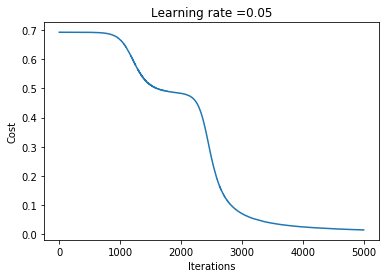

In [15]:
parameters = model(training_inputs.T, training_labels.reshape(1, -1), [2, 3, 1], learning_rate = 0.05, num_iterations = 5000)

In [16]:
def predict(X, parameters):
    num_examples = X.shape[1]
    num_layers = len(parameters)
    predictions = np.zeros((1, num_examples))
    
    # Forward propagation
    probabilities, caches = model_forward(X, parameters)
    
    # Convert probabilities to 0/1
    for i in range(0, probabilities.shape[1]):
        if probabilities[0, i] > 0.5:
            predictions[0, i] = 1
        else:
            predictions[0, i] = 0
            
    return predictions

In [17]:
predict_on = np.array([
    np.array([1, 1]),
    np.array([1, 0]),
    np.array([0, 1]),
    np.array([0, 0])
])

predictions = predict(predict_on.T, parameters)

print(predictions)

[[0. 1. 1. 0.]]
